#### Se uso al implementación de ProGAN disponible en el repositorio de GitHub siguiente:   

https://github.com/TAUIL-Abd-Elilah/Generative-Adversarial-Networks--GANs/blob/main/progan-implementation-from-scratch-pytorch.ipynb

In [1]:
from math import log2
import random
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()


In [3]:
DATASET                 = './celeba_hq/train/'
START_TRAIN_AT_IMG_SIZE = 4
DEVICE                  = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE           = 1e-3
#BATCH_SIZES             = [32, 32, 32, 16, 16, 16]
BATCH_SIZES             = [64, 64, 32, 32, 32, 16, 8, 4]
#image_size              = 128
image_size              = 512
CHANNELS_IMG            = 3
Z_DIM                   = 256  
IN_CHANNELS             = 256  
CRITIC_ITERATIONS       = 1
LAMBDA_GP               = 10
PROGRESSIVE_EPOCHS      = [30] * len(BATCH_SIZES)
FIXED_NOISE             = torch.randn(9, Z_DIM, 1, 1).to(DEVICE)


In [4]:
def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5 for _ in range(CHANNELS_IMG)],
                [0.5 for _ in range(CHANNELS_IMG)],
            ),
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    dataset = datasets.ImageFolder(root=DATASET, transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    return loader, dataset


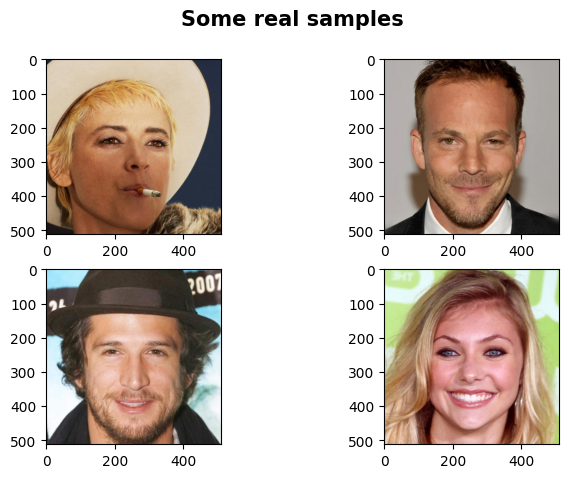

In [5]:
def check_loader():
    #loader,_ = get_loader(128)
    loader,_ = get_loader(512)
    cloth ,_ = next(iter(loader))
    _, ax = plt.subplots(2,2, figsize=(8,5))
    plt.suptitle('Some real samples', fontsize=15, fontweight='bold')
    ind = 0 
    for k in range(2):
        for kk in range(2):
            
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2) 
            ind += 1
check_loader()


In [6]:
factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]


class WSConv2d(nn.Module):

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)


class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x


class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(
            len(factors) - 1
        ):  
            conv_in_c = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps):
        out = self.initial(x)

        if steps == 0:
            return self.initial_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)


class Discriminator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)


        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  
        self.final_block = nn.Sequential(
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ), 
        )

    def fade_in(self, alpha, downscaled, out):

        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )

        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):

        cur_step = len(self.prog_blocks) - steps


        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)


        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))


        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)


In [7]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty



In [8]:
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM, 1, 1).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()


In [9]:
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
):
    loop = tqdm(loader, leave=True)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]

        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(DEVICE)

        fake = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, device=DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001 * torch.mean(critic_real ** 2))
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        alpha += cur_batch_size / (
            (PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1)

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
        )
        

    return alpha


In [10]:
gen = Generator(
    Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)
critic = Discriminator(
    Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99)
)
scaler_critic = torch.cuda.amp.GradScaler()
scaler_gen = torch.cuda.amp.GradScaler()




gen.train()
critic.train()

tensorboard_step = 0
step = int(log2(START_TRAIN_AT_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-5  
    loader, dataset = get_loader(4 * 2 ** step)  
    print(f"Current image size: {4 * 2 ** step}")

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        alpha = train_fn(
            critic,
            gen,
            loader,
            dataset,
            step,
            alpha,
            opt_critic,
            opt_gen,
        )
    generate_examples(gen, step, n=100)


    step += 1  

 



Current image size: 4
Epoch [1/30]


100%|██████████| 438/438 [01:45<00:00,  4.14it/s, gp=0.0121, loss_critic=-0.037]


Epoch [2/30]


100%|█████████| 438/438 [01:38<00:00,  4.44it/s, gp=0.00772, loss_critic=0.0355]


Epoch [3/30]


100%|████████| 438/438 [01:41<00:00,  4.32it/s, gp=0.00462, loss_critic=0.00537]


Epoch [4/30]


100%|█████████| 438/438 [01:40<00:00,  4.36it/s, gp=0.00363, loss_critic=0.0124]


Epoch [5/30]


100%|█████████| 438/438 [01:32<00:00,  4.73it/s, gp=0.00781, loss_critic=0.0465]


Epoch [6/30]


100%|████████████| 438/438 [01:38<00:00,  4.45it/s, gp=0.011, loss_critic=0.296]


Epoch [7/30]


100%|█████████| 438/438 [01:33<00:00,  4.70it/s, gp=0.00332, loss_critic=-0.165]


Epoch [8/30]


100%|███████| 438/438 [01:42<00:00,  4.29it/s, gp=0.00501, loss_critic=-0.00625]


Epoch [9/30]


100%|██████████| 438/438 [01:37<00:00,  4.50it/s, gp=0.00484, loss_critic=0.107]


Epoch [10/30]


100%|█████████| 438/438 [01:33<00:00,  4.67it/s, gp=0.00508, loss_critic=0.0744]


Epoch [11/30]


100%|██████████| 438/438 [01:32<00:00,  4.72it/s, gp=0.00728, loss_critic=0.129]


Epoch [12/30]


100%|██████████| 438/438 [01:39<00:00,  4.41it/s, gp=0.0053, loss_critic=0.0397]


Epoch [13/30]


100%|█████████| 438/438 [01:38<00:00,  4.46it/s, gp=0.00336, loss_critic=0.0169]


Epoch [14/30]


100%|████████| 438/438 [01:38<00:00,  4.46it/s, gp=0.00477, loss_critic=-0.0576]


Epoch [15/30]


100%|█████████| 438/438 [01:38<00:00,  4.45it/s, gp=0.00334, loss_critic=-0.107]


Epoch [16/30]


100%|████████| 438/438 [01:40<00:00,  4.35it/s, gp=0.00215, loss_critic=-0.0199]


Epoch [17/30]


100%|█████████| 438/438 [01:35<00:00,  4.57it/s, gp=0.00232, loss_critic=0.0118]


Epoch [18/30]


100%|██████████| 438/438 [01:34<00:00,  4.61it/s, gp=0.00444, loss_critic=0.099]


Epoch [19/30]


100%|█████████| 438/438 [01:32<00:00,  4.76it/s, gp=0.00315, loss_critic=0.0659]


Epoch [20/30]


100%|█████████| 438/438 [01:36<00:00,  4.55it/s, gp=0.00254, loss_critic=0.0579]


Epoch [21/30]


100%|██████████| 438/438 [01:36<00:00,  4.55it/s, gp=0.00272, loss_critic=0.101]


Epoch [22/30]


100%|███████| 438/438 [01:36<00:00,  4.56it/s, gp=0.00237, loss_critic=-0.00696]


Epoch [23/30]


100%|████████| 438/438 [01:38<00:00,  4.43it/s, gp=0.00191, loss_critic=-0.0199]


Epoch [24/30]


100%|█████████| 438/438 [01:35<00:00,  4.61it/s, gp=0.00345, loss_critic=0.0118]


Epoch [25/30]


100%|██████████| 438/438 [01:36<00:00,  4.54it/s, gp=0.0026, loss_critic=0.0336]


Epoch [26/30]


100%|█████████| 438/438 [01:35<00:00,  4.58it/s, gp=0.00261, loss_critic=0.0541]


Epoch [27/30]


100%|████████| 438/438 [01:35<00:00,  4.57it/s, gp=0.00492, loss_critic=-0.0288]


Epoch [28/30]


100%|█████████| 438/438 [01:32<00:00,  4.71it/s, gp=0.00145, loss_critic=0.0478]


Epoch [29/30]


100%|████████| 438/438 [01:31<00:00,  4.78it/s, gp=0.00195, loss_critic=-0.0382]


Epoch [30/30]


100%|█████████| 438/438 [01:31<00:00,  4.81it/s, gp=0.00264, loss_critic=0.0547]


Current image size: 8
Epoch [1/30]


  0%|                                                   | 0/438 [00:00<?, ?it/s]/home/roger/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 438/438 [01:46<00:00,  4.12it/s, gp=0.00249, loss_critic=0.188]


Epoch [2/30]


100%|█████████| 438/438 [01:45<00:00,  4.14it/s, gp=0.00339, loss_critic=-0.378]


Epoch [3/30]


100%|█████████| 438/438 [01:46<00:00,  4.12it/s, gp=0.00331, loss_critic=0.0331]


Epoch [4/30]


100%|██████████| 438/438 [01:46<00:00,  4.10it/s, gp=0.00301, loss_critic=0.154]


Epoch [5/30]


100%|██████████| 438/438 [01:47<00:00,  4.08it/s, gp=0.00682, loss_critic=0.344]


Epoch [6/30]


100%|█████████| 438/438 [01:46<00:00,  4.12it/s, gp=0.00213, loss_critic=0.0097]


Epoch [7/30]


100%|██████████| 438/438 [01:46<00:00,  4.12it/s, gp=0.00576, loss_critic=0.164]


Epoch [8/30]


100%|██████████| 438/438 [01:45<00:00,  4.14it/s, gp=0.0021, loss_critic=-0.173]


Epoch [9/30]


100%|████████| 438/438 [01:45<00:00,  4.16it/s, gp=0.00209, loss_critic=-0.0425]


Epoch [10/30]


100%|██████████| 438/438 [01:45<00:00,  4.14it/s, gp=0.00734, loss_critic=0.126]


Epoch [11/30]


100%|██████████| 438/438 [01:45<00:00,  4.14it/s, gp=0.0033, loss_critic=0.0413]


Epoch [12/30]


100%|█████████| 438/438 [01:45<00:00,  4.15it/s, gp=0.00239, loss_critic=-0.173]


Epoch [13/30]


100%|████████| 438/438 [01:45<00:00,  4.17it/s, gp=0.00279, loss_critic=-0.0415]


Epoch [14/30]


100%|██████████| 438/438 [01:45<00:00,  4.16it/s, gp=0.00446, loss_critic=0.362]


Epoch [15/30]


100%|█████████| 438/438 [01:45<00:00,  4.14it/s, gp=0.00196, loss_critic=0.0678]


Epoch [16/30]


100%|█████████| 438/438 [01:46<00:00,  4.12it/s, gp=0.00448, loss_critic=0.0645]


Epoch [17/30]


100%|██████████| 438/438 [01:46<00:00,  4.12it/s, gp=0.00471, loss_critic=0.122]


Epoch [18/30]


100%|█████████| 438/438 [01:45<00:00,  4.13it/s, gp=0.00251, loss_critic=0.0674]


Epoch [19/30]


100%|██████████| 438/438 [01:45<00:00,  4.14it/s, gp=0.00228, loss_critic=0.116]


Epoch [20/30]


100%|████████| 438/438 [01:45<00:00,  4.14it/s, gp=0.00289, loss_critic=-0.0505]


Epoch [21/30]


100%|█████████| 438/438 [01:46<00:00,  4.13it/s, gp=0.00477, loss_critic=0.0843]


Epoch [22/30]


100%|███████████| 438/438 [01:45<00:00,  4.15it/s, gp=0.00333, loss_critic=0.12]


Epoch [23/30]


100%|█████████| 438/438 [01:45<00:00,  4.15it/s, gp=0.00264, loss_critic=0.0949]


Epoch [24/30]


100%|██████████| 438/438 [01:45<00:00,  4.15it/s, gp=0.00435, loss_critic=0.331]


Epoch [25/30]


100%|██████████| 438/438 [01:45<00:00,  4.13it/s, gp=0.00623, loss_critic=0.275]


Epoch [26/30]


100%|█████████| 438/438 [01:44<00:00,  4.18it/s, gp=0.00526, loss_critic=0.0284]


Epoch [27/30]


100%|████████| 438/438 [01:46<00:00,  4.12it/s, gp=0.00345, loss_critic=-0.0336]


Epoch [28/30]


100%|████████| 438/438 [01:46<00:00,  4.10it/s, gp=0.00325, loss_critic=0.00214]


Epoch [29/30]


100%|█████████| 438/438 [01:46<00:00,  4.10it/s, gp=0.00271, loss_critic=0.0513]


Epoch [30/30]


100%|█████████| 438/438 [01:47<00:00,  4.07it/s, gp=0.00261, loss_critic=-0.106]


Current image size: 16
Epoch [1/30]


100%|█████████| 875/875 [02:21<00:00,  6.19it/s, gp=0.00473, loss_critic=-0.175]


Epoch [2/30]


100%|█████████| 875/875 [02:21<00:00,  6.18it/s, gp=0.00301, loss_critic=-0.417]


Epoch [3/30]


100%|█████████| 875/875 [02:21<00:00,  6.18it/s, gp=0.00181, loss_critic=0.0224]


Epoch [4/30]


100%|████████████| 875/875 [02:20<00:00,  6.23it/s, gp=0.003, loss_critic=0.495]


Epoch [5/30]


100%|██████████| 875/875 [02:20<00:00,  6.21it/s, gp=0.00298, loss_critic=0.194]


Epoch [6/30]


100%|████████| 875/875 [02:21<00:00,  6.20it/s, gp=0.00379, loss_critic=-0.0381]


Epoch [7/30]


100%|████████| 875/875 [02:20<00:00,  6.24it/s, gp=0.00634, loss_critic=-0.0153]


Epoch [8/30]


100%|█████████| 875/875 [02:21<00:00,  6.16it/s, gp=0.00444, loss_critic=-0.054]


Epoch [9/30]


100%|█████████| 875/875 [02:21<00:00,  6.18it/s, gp=0.00206, loss_critic=0.0621]


Epoch [10/30]


100%|██████████| 875/875 [02:20<00:00,  6.21it/s, gp=0.00533, loss_critic=0.214]


Epoch [11/30]


100%|█████████| 875/875 [02:21<00:00,  6.19it/s, gp=0.00476, loss_critic=-0.219]


Epoch [12/30]


100%|█████████| 875/875 [02:21<00:00,  6.19it/s, gp=0.00302, loss_critic=-0.202]


Epoch [13/30]


100%|█████████| 875/875 [02:21<00:00,  6.19it/s, gp=0.00317, loss_critic=0.0729]


Epoch [14/30]


100%|█████████| 875/875 [02:20<00:00,  6.21it/s, gp=0.00279, loss_critic=-0.251]


Epoch [15/30]


100%|█████████| 875/875 [02:20<00:00,  6.21it/s, gp=0.00451, loss_critic=0.0398]


Epoch [16/30]


100%|█████████| 875/875 [02:21<00:00,  6.20it/s, gp=0.00451, loss_critic=-0.231]


Epoch [17/30]


100%|██████████| 875/875 [02:21<00:00,  6.20it/s, gp=0.00746, loss_critic=0.295]


Epoch [18/30]


100%|████████| 875/875 [02:21<00:00,  6.17it/s, gp=0.00286, loss_critic=-0.0305]


Epoch [19/30]


100%|████████| 875/875 [02:22<00:00,  6.14it/s, gp=0.00294, loss_critic=-0.0957]


Epoch [20/30]


100%|█████████| 875/875 [02:21<00:00,  6.18it/s, gp=0.00479, loss_critic=-0.168]


Epoch [21/30]


100%|█████████| 875/875 [02:21<00:00,  6.18it/s, gp=0.00305, loss_critic=-0.111]


Epoch [22/30]


100%|█████████| 875/875 [02:21<00:00,  6.17it/s, gp=0.00225, loss_critic=-0.132]


Epoch [23/30]


100%|█████████| 875/875 [02:22<00:00,  6.15it/s, gp=0.00175, loss_critic=-0.034]


Epoch [24/30]


100%|████████| 875/875 [02:22<00:00,  6.15it/s, gp=0.00263, loss_critic=-0.0614]


Epoch [25/30]


100%|████████| 875/875 [02:21<00:00,  6.17it/s, gp=0.00171, loss_critic=0.00179]


Epoch [26/30]


100%|██████████| 875/875 [02:21<00:00,  6.17it/s, gp=0.0037, loss_critic=-0.226]


Epoch [27/30]


100%|█████████| 875/875 [02:21<00:00,  6.18it/s, gp=0.00273, loss_critic=-0.281]


Epoch [28/30]


100%|████████| 875/875 [02:21<00:00,  6.17it/s, gp=0.00406, loss_critic=-0.0472]


Epoch [29/30]


100%|█████████| 875/875 [02:21<00:00,  6.17it/s, gp=0.00336, loss_critic=0.0278]


Epoch [30/30]


100%|██████████| 875/875 [02:21<00:00,  6.18it/s, gp=0.00395, loss_critic=0.409]


Current image size: 32
Epoch [1/30]


100%|████████████| 875/875 [04:57<00:00,  2.95it/s, gp=0.0219, loss_critic=1.02]


Epoch [2/30]


100%|████████████| 875/875 [04:56<00:00,  2.95it/s, gp=0.0864, loss_critic=1.67]


Epoch [3/30]


100%|████████████| 875/875 [04:55<00:00,  2.96it/s, gp=0.0745, loss_critic=4.71]


Epoch [4/30]


100%|███████████| 875/875 [04:56<00:00,  2.95it/s, gp=0.0833, loss_critic=0.472]


Epoch [5/30]


100%|█████████████| 875/875 [04:56<00:00,  2.96it/s, gp=0.139, loss_critic=1.25]


Epoch [6/30]


100%|███████████| 875/875 [04:57<00:00,  2.95it/s, gp=0.00619, loss_critic=1.72]


Epoch [7/30]


100%|████████████| 875/875 [04:56<00:00,  2.95it/s, gp=0.0115, loss_critic=1.88]


Epoch [8/30]


100%|███████████| 875/875 [04:56<00:00,  2.95it/s, gp=0.0272, loss_critic=-1.89]


Epoch [9/30]


100%|██████████| 875/875 [04:56<00:00,  2.95it/s, gp=0.0136, loss_critic=-0.551]


Epoch [10/30]


100%|█████████| 875/875 [04:55<00:00,  2.96it/s, gp=0.0228, loss_critic=-0.0481]


Epoch [11/30]


100%|████████████| 875/875 [04:56<00:00,  2.95it/s, gp=0.0124, loss_critic=3.46]


Epoch [12/30]


100%|█████████| 875/875 [04:55<00:00,  2.96it/s, gp=0.0199, loss_critic=0.00236]


Epoch [13/30]


100%|███████████| 875/875 [04:56<00:00,  2.95it/s, gp=0.0264, loss_critic=0.261]


Epoch [14/30]


100%|██████████| 875/875 [04:55<00:00,  2.96it/s, gp=0.0107, loss_critic=-0.186]


Epoch [15/30]


100%|███████████| 875/875 [04:56<00:00,  2.96it/s, gp=0.0106, loss_critic=0.695]


Epoch [16/30]


100%|█████████| 875/875 [04:57<00:00,  2.94it/s, gp=0.00541, loss_critic=-0.131]


Epoch [17/30]


100%|███████| 875/875 [04:56<00:00,  2.95it/s, gp=0.00416, loss_critic=-0.00465]


Epoch [18/30]


100%|█████████| 875/875 [04:54<00:00,  2.97it/s, gp=0.00553, loss_critic=-0.111]


Epoch [19/30]


100%|█████████████| 875/875 [04:56<00:00,  2.95it/s, gp=0.158, loss_critic=2.09]


Epoch [20/30]


100%|███████████| 875/875 [04:55<00:00,  2.96it/s, gp=0.0134, loss_critic=0.163]


Epoch [21/30]


100%|███████████| 875/875 [04:55<00:00,  2.96it/s, gp=0.0132, loss_critic=0.343]


Epoch [22/30]


100%|█████████| 875/875 [04:56<00:00,  2.95it/s, gp=0.00844, loss_critic=-0.242]


Epoch [23/30]


100%|██████████| 875/875 [04:56<00:00,  2.95it/s, gp=0.00492, loss_critic=0.027]


Epoch [24/30]


100%|████████████| 875/875 [04:55<00:00,  2.96it/s, gp=0.0284, loss_critic=0.56]


Epoch [25/30]


100%|███████████| 875/875 [04:56<00:00,  2.95it/s, gp=0.0134, loss_critic=0.397]


Epoch [26/30]


100%|██████████| 875/875 [04:56<00:00,  2.95it/s, gp=0.0156, loss_critic=-0.124]


Epoch [27/30]


100%|██████████| 875/875 [04:56<00:00,  2.95it/s, gp=0.00493, loss_critic=0.205]


Epoch [28/30]


100%|█████████| 875/875 [04:58<00:00,  2.93it/s, gp=0.00986, loss_critic=0.0973]


Epoch [29/30]


100%|██████████| 875/875 [04:56<00:00,  2.95it/s, gp=0.00582, loss_critic=0.072]


Epoch [30/30]


100%|█████████| 875/875 [04:56<00:00,  2.95it/s, gp=0.00262, loss_critic=-0.166]


Current image size: 64
Epoch [1/30]


  0%|                                                   | 0/875 [00:00<?, ?it/s]/home/roger/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 4.19 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/roger/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 8.25 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|████████████| 875/875 [11:05<00:00,  1.31it/s, gp=0.0139, loss_critic=1.14]


Epoch [2/30]


100%|████████████| 875/875 [11:03<00:00,  1.32it/s, gp=0.0501, loss_critic=1.75]


Epoch [3/30]


100%|██████████| 875/875 [11:03<00:00,  1.32it/s, gp=0.00398, loss_critic=0.223]


Epoch [4/30]


100%|██████████| 875/875 [11:04<00:00,  1.32it/s, gp=0.0119, loss_critic=-0.121]


Epoch [5/30]


100%|██████████| 875/875 [11:04<00:00,  1.32it/s, gp=0.0052, loss_critic=-0.383]


Epoch [6/30]


100%|███████████| 875/875 [11:04<00:00,  1.32it/s, gp=0.00352, loss_critic=-1.1]


Epoch [7/30]


100%|██████████| 875/875 [11:02<00:00,  1.32it/s, gp=0.0024, loss_critic=-0.434]


Epoch [8/30]


100%|██████████| 875/875 [11:04<00:00,  1.32it/s, gp=0.00659, loss_critic=-1.31]


Epoch [9/30]


100%|█████████| 875/875 [11:05<00:00,  1.31it/s, gp=0.00863, loss_critic=-0.522]


Epoch [10/30]


100%|██████████| 875/875 [11:06<00:00,  1.31it/s, gp=0.00521, loss_critic=-1.15]


Epoch [11/30]


100%|█████████| 875/875 [11:04<00:00,  1.32it/s, gp=0.00381, loss_critic=-0.658]


Epoch [12/30]


100%|█████████| 875/875 [11:05<00:00,  1.31it/s, gp=0.00919, loss_critic=-0.228]


Epoch [13/30]


100%|██████████| 875/875 [11:05<00:00,  1.32it/s, gp=0.00378, loss_critic=0.864]


Epoch [14/30]


100%|█████████| 875/875 [11:07<00:00,  1.31it/s, gp=0.00433, loss_critic=-0.856]


Epoch [15/30]


100%|█████████| 875/875 [11:07<00:00,  1.31it/s, gp=0.00256, loss_critic=-0.267]


Epoch [16/30]


100%|█████████| 875/875 [11:06<00:00,  1.31it/s, gp=0.00353, loss_critic=-0.591]


Epoch [17/30]


100%|█████████| 875/875 [11:04<00:00,  1.32it/s, gp=0.00658, loss_critic=-0.899]


Epoch [18/30]


100%|█████████| 875/875 [11:06<00:00,  1.31it/s, gp=0.00489, loss_critic=-0.966]


Epoch [19/30]


100%|███████████| 875/875 [11:03<00:00,  1.32it/s, gp=0.0121, loss_critic=-1.11]


Epoch [20/30]


100%|█████████| 875/875 [11:06<00:00,  1.31it/s, gp=0.00462, loss_critic=-0.653]


Epoch [21/30]


100%|█████████| 875/875 [11:06<00:00,  1.31it/s, gp=0.00268, loss_critic=-0.518]


Epoch [22/30]


100%|█████████| 875/875 [11:04<00:00,  1.32it/s, gp=0.00586, loss_critic=-0.733]


Epoch [23/30]


100%|█████████| 875/875 [11:03<00:00,  1.32it/s, gp=0.00349, loss_critic=-0.568]


Epoch [24/30]


100%|█████████| 875/875 [11:07<00:00,  1.31it/s, gp=0.00704, loss_critic=-0.811]


Epoch [25/30]


100%|█████████| 875/875 [11:04<00:00,  1.32it/s, gp=0.00599, loss_critic=-0.969]


Epoch [26/30]


100%|█████████| 875/875 [11:01<00:00,  1.32it/s, gp=0.00407, loss_critic=-0.844]


Epoch [27/30]


100%|█████████| 875/875 [11:02<00:00,  1.32it/s, gp=0.00353, loss_critic=-0.504]


Epoch [28/30]


100%|█████████| 875/875 [11:03<00:00,  1.32it/s, gp=0.00397, loss_critic=-0.824]


Epoch [29/30]


100%|██████████| 875/875 [11:02<00:00,  1.32it/s, gp=0.0047, loss_critic=-0.911]


Epoch [30/30]


100%|█████████| 875/875 [11:02<00:00,  1.32it/s, gp=0.00962, loss_critic=-0.221]


Current image size: 128
Epoch [1/30]


100%|█████████| 1750/1750 [21:55<00:00,  1.33it/s, gp=0.0116, loss_critic=-1.66]


Epoch [2/30]


100%|████████| 1750/1750 [21:52<00:00,  1.33it/s, gp=0.00927, loss_critic=-1.85]


Epoch [3/30]


100%|█████████| 1750/1750 [21:58<00:00,  1.33it/s, gp=0.0143, loss_critic=-1.06]


Epoch [4/30]


100%|██████| 1750/1750 [21:50<00:00,  1.34it/s, gp=0.00803, loss_critic=-0.0604]


Epoch [5/30]


100%|████████| 1750/1750 [21:53<00:00,  1.33it/s, gp=0.00359, loss_critic=-1.22]


Epoch [6/30]


100%|████████| 1750/1750 [21:53<00:00,  1.33it/s, gp=0.0143, loss_critic=-0.387]


Epoch [7/30]


100%|██████████| 1750/1750 [21:57<00:00,  1.33it/s, gp=0.014, loss_critic=-2.19]


Epoch [8/30]


100%|█████████| 1750/1750 [21:47<00:00,  1.34it/s, gp=0.0115, loss_critic=-2.88]


Epoch [9/30]


100%|█████████| 1750/1750 [21:48<00:00,  1.34it/s, gp=0.00962, loss_critic=0.23]


Epoch [10/30]


100%|████████| 1750/1750 [21:51<00:00,  1.33it/s, gp=0.00295, loss_critic=-2.13]


Epoch [11/30]


100%|████████| 1750/1750 [21:52<00:00,  1.33it/s, gp=0.00346, loss_critic=-1.34]


Epoch [12/30]


100%|████████| 1750/1750 [21:51<00:00,  1.33it/s, gp=0.00431, loss_critic=-2.09]


Epoch [13/30]


100%|███████| 1750/1750 [21:54<00:00,  1.33it/s, gp=0.00811, loss_critic=-0.361]


Epoch [14/30]


100%|████████| 1750/1750 [21:50<00:00,  1.34it/s, gp=0.0211, loss_critic=-0.837]


Epoch [15/30]


100%|█████████| 1750/1750 [21:51<00:00,  1.33it/s, gp=0.0084, loss_critic=-1.36]


Epoch [16/30]


100%|████████| 1750/1750 [21:49<00:00,  1.34it/s, gp=0.0154, loss_critic=-0.875]


Epoch [17/30]


100%|█████████| 1750/1750 [21:52<00:00,  1.33it/s, gp=0.0139, loss_critic=-1.82]


Epoch [18/30]


100%|████████| 1750/1750 [21:54<00:00,  1.33it/s, gp=0.0116, loss_critic=-0.685]


Epoch [19/30]


100%|██████████| 1750/1750 [21:52<00:00,  1.33it/s, gp=0.0164, loss_critic=2.24]


Epoch [20/30]


100%|████████| 1750/1750 [21:56<00:00,  1.33it/s, gp=0.00435, loss_critic=-1.08]


Epoch [21/30]


100%|████████| 1750/1750 [21:55<00:00,  1.33it/s, gp=0.00556, loss_critic=0.818]


Epoch [22/30]


100%|███████| 1750/1750 [21:50<00:00,  1.34it/s, gp=0.00359, loss_critic=-0.406]


Epoch [23/30]


100%|███████| 1750/1750 [21:52<00:00,  1.33it/s, gp=0.00659, loss_critic=-0.325]


Epoch [24/30]


100%|████████| 1750/1750 [21:50<00:00,  1.34it/s, gp=0.00236, loss_critic=-1.73]


Epoch [25/30]


100%|████████| 1750/1750 [21:51<00:00,  1.33it/s, gp=0.0058, loss_critic=-0.216]


Epoch [26/30]


100%|██████████| 1750/1750 [21:44<00:00,  1.34it/s, gp=0.005, loss_critic=-1.51]


Epoch [27/30]


100%|█████████| 1750/1750 [21:48<00:00,  1.34it/s, gp=0.0276, loss_critic=-2.16]


Epoch [28/30]


100%|███████| 1750/1750 [21:48<00:00,  1.34it/s, gp=0.00933, loss_critic=-0.209]


Epoch [29/30]


100%|███████| 1750/1750 [21:48<00:00,  1.34it/s, gp=0.00361, loss_critic=-0.288]


Epoch [30/30]


100%|████████| 1750/1750 [21:48<00:00,  1.34it/s, gp=0.00599, loss_critic=-1.25]


Current image size: 256
Epoch [1/30]


100%|████████████| 3500/3500 [45:05<00:00,  1.29it/s, gp=0.417, loss_critic=1.9]


Epoch [2/30]


100%|███████████| 3500/3500 [45:07<00:00,  1.29it/s, gp=0.168, loss_critic=4.21]


Epoch [3/30]


100%|██████████| 3500/3500 [45:12<00:00,  1.29it/s, gp=0.0517, loss_critic=13.7]


Epoch [4/30]


100%|█████████| 3500/3500 [45:13<00:00,  1.29it/s, gp=0.0251, loss_critic=-8.15]


Epoch [5/30]


100%|█████████| 3500/3500 [45:10<00:00,  1.29it/s, gp=0.0368, loss_critic=-1.81]


Epoch [6/30]


100%|███████████| 3500/3500 [45:14<00:00,  1.29it/s, gp=0.783, loss_critic=8.92]


Epoch [7/30]


100%|████████| 3500/3500 [45:24<00:00,  1.28it/s, gp=0.0806, loss_critic=-0.307]


Epoch [8/30]


100%|██████████| 3500/3500 [45:16<00:00,  1.29it/s, gp=0.197, loss_critic=-8.08]


Epoch [9/30]


100%|███████████| 3500/3500 [45:26<00:00,  1.28it/s, gp=0.684, loss_critic=7.42]


Epoch [10/30]


100%|██████████| 3500/3500 [45:30<00:00,  1.28it/s, gp=0.126, loss_critic=-4.42]


Epoch [11/30]


100%|██████████| 3500/3500 [45:19<00:00,  1.29it/s, gp=0.0433, loss_critic=1.67]


Epoch [12/30]


100%|████████████| 3500/3500 [44:43<00:00,  1.30it/s, gp=0.0154, loss_critic=-6]


Epoch [13/30]


100%|█████████| 3500/3500 [44:47<00:00,  1.30it/s, gp=0.0124, loss_critic=-1.11]


Epoch [14/30]


100%|█████████| 3500/3500 [44:47<00:00,  1.30it/s, gp=0.0121, loss_critic=-2.65]


Epoch [15/30]


100%|████████| 3500/3500 [44:49<00:00,  1.30it/s, gp=0.00446, loss_critic=-2.83]


Epoch [16/30]


100%|█████████| 3500/3500 [44:48<00:00,  1.30it/s, gp=0.0596, loss_critic=-3.51]


Epoch [17/30]


100%|█████████| 3500/3500 [44:51<00:00,  1.30it/s, gp=0.0376, loss_critic=-3.96]


Epoch [18/30]


100%|█████████| 3500/3500 [44:47<00:00,  1.30it/s, gp=0.0171, loss_critic=-2.65]


Epoch [19/30]


100%|█████████| 3500/3500 [44:43<00:00,  1.30it/s, gp=0.0128, loss_critic=0.138]


Epoch [20/30]


100%|████████| 3500/3500 [44:50<00:00,  1.30it/s, gp=0.00561, loss_critic=-5.63]


Epoch [21/30]


100%|█████████| 3500/3500 [44:55<00:00,  1.30it/s, gp=0.0178, loss_critic=-6.11]


Epoch [22/30]


100%|████████| 3500/3500 [45:04<00:00,  1.29it/s, gp=0.00462, loss_critic=-2.56]


Epoch [23/30]


100%|█████████| 3500/3500 [45:25<00:00,  1.28it/s, gp=0.0395, loss_critic=-1.55]


Epoch [24/30]


100%|█████████| 3500/3500 [45:17<00:00,  1.29it/s, gp=0.0107, loss_critic=-2.11]


Epoch [25/30]


100%|████████| 3500/3500 [45:13<00:00,  1.29it/s, gp=0.00651, loss_critic=-4.51]


Epoch [26/30]


100%|█████████| 3500/3500 [45:07<00:00,  1.29it/s, gp=0.0156, loss_critic=-2.43]


Epoch [27/30]


100%|█████████| 3500/3500 [45:11<00:00,  1.29it/s, gp=0.0041, loss_critic=-2.64]


Epoch [28/30]


100%|███████| 3500/3500 [45:12<00:00,  1.29it/s, gp=0.00614, loss_critic=-0.777]


Epoch [29/30]


100%|█████████| 3500/3500 [45:09<00:00,  1.29it/s, gp=0.00776, loss_critic=2.87]


Epoch [30/30]


100%|█████████| 3500/3500 [45:11<00:00,  1.29it/s, gp=0.0305, loss_critic=-1.07]


Current image size: 512
Epoch [1/30]


100%|███████| 7000/7000 [1:26:25<00:00,  1.35it/s, gp=0.0508, loss_critic=-9.19]


Epoch [2/30]


100%|███████| 7000/7000 [1:26:18<00:00,  1.35it/s, gp=0.0855, loss_critic=-10.3]


Epoch [3/30]


100%|████████| 7000/7000 [1:26:55<00:00,  1.34it/s, gp=0.0148, loss_critic=18.4]


Epoch [4/30]


100%|██████████| 7000/7000 [1:26:51<00:00,  1.34it/s, gp=0.16, loss_critic=4.36]


Epoch [5/30]


100%|██████| 7000/7000 [1:26:50<00:00,  1.34it/s, gp=0.0718, loss_critic=-0.121]


Epoch [6/30]


100%|████████| 7000/7000 [1:26:48<00:00,  1.34it/s, gp=0.0344, loss_critic=5.12]


Epoch [7/30]


100%|███████| 7000/7000 [1:26:49<00:00,  1.34it/s, gp=0.0476, loss_critic=-4.14]


Epoch [8/30]


100%|████████| 7000/7000 [1:26:51<00:00,  1.34it/s, gp=0.0528, loss_critic=3.06]


Epoch [9/30]


100%|████████| 7000/7000 [1:26:50<00:00,  1.34it/s, gp=0.0694, loss_critic=19.7]


Epoch [10/30]


100%|█████████| 7000/7000 [1:26:47<00:00,  1.34it/s, gp=0.105, loss_critic=2.13]


Epoch [11/30]


100%|███████| 7000/7000 [1:26:49<00:00,  1.34it/s, gp=0.0191, loss_critic=-1.61]


Epoch [12/30]


100%|████████| 7000/7000 [1:26:49<00:00,  1.34it/s, gp=0.0395, loss_critic=1.06]


Epoch [13/30]


100%|███████| 7000/7000 [1:26:47<00:00,  1.34it/s, gp=0.0319, loss_critic=-4.35]


Epoch [14/30]


100%|██████| 7000/7000 [1:26:50<00:00,  1.34it/s, gp=0.0611, loss_critic=-0.267]


Epoch [15/30]


100%|███████| 7000/7000 [1:26:51<00:00,  1.34it/s, gp=0.0619, loss_critic=-8.87]


Epoch [16/30]


100%|█████████| 7000/7000 [1:26:53<00:00,  1.34it/s, gp=0.067, loss_critic=5.12]


Epoch [17/30]


100%|███████| 7000/7000 [1:26:53<00:00,  1.34it/s, gp=0.0585, loss_critic=-10.2]


Epoch [18/30]


100%|████████| 7000/7000 [1:26:53<00:00,  1.34it/s, gp=0.0734, loss_critic=12.7]


Epoch [19/30]


100%|███████| 7000/7000 [1:26:52<00:00,  1.34it/s, gp=0.00477, loss_critic=2.85]


Epoch [20/30]


100%|████████| 7000/7000 [1:26:49<00:00,  1.34it/s, gp=0.0222, loss_critic=8.05]


Epoch [21/30]


100%|███████| 7000/7000 [1:26:54<00:00,  1.34it/s, gp=0.0749, loss_critic=-1.63]


Epoch [22/30]


100%|█████████| 7000/7000 [1:26:54<00:00,  1.34it/s, gp=0.111, loss_critic=5.96]


Epoch [23/30]


100%|█████████| 7000/7000 [1:26:51<00:00,  1.34it/s, gp=0.0125, loss_critic=5.3]


Epoch [24/30]


100%|█████████| 7000/7000 [1:26:54<00:00,  1.34it/s, gp=0.0132, loss_critic=-12]


Epoch [25/30]


100%|███████| 7000/7000 [1:26:53<00:00,  1.34it/s, gp=0.0668, loss_critic=-2.18]


Epoch [26/30]


100%|███████| 7000/7000 [1:26:55<00:00,  1.34it/s, gp=0.0278, loss_critic=-11.2]


Epoch [27/30]


100%|███████| 7000/7000 [1:26:52<00:00,  1.34it/s, gp=0.0188, loss_critic=-7.91]


Epoch [28/30]


100%|███████| 7000/7000 [1:26:54<00:00,  1.34it/s, gp=0.0266, loss_critic=-8.92]


Epoch [29/30]


100%|███████| 7000/7000 [1:26:55<00:00,  1.34it/s, gp=0.0583, loss_critic=-8.73]


Epoch [30/30]


100%|███████| 7000/7000 [1:26:53<00:00,  1.34it/s, gp=0.0258, loss_critic=-7.33]


#### Generamos 10000 imágenes de personas con resolución 512x512

In [14]:
steps = 7
n=10000
gen.eval()
alpha = 1.0
for i in range(n):
    with torch.no_grad():
        noise = torch.randn(1, Z_DIM, 1, 1).to(DEVICE)
        img = gen(noise, alpha, steps)
        if not os.path.exists(f'saved_examples/final'):
            os.makedirs(f'saved_examples/final')
        save_image(img*0.5+0.5, f"saved_examples/final/img_{i}.png")
gen.train()

Generator(
  (initial): Sequential(
    (0): PixelNorm()
    (1): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(1, 1))
    (2): LeakyReLU(negative_slope=0.2)
    (3): WSConv2d(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (4): LeakyReLU(negative_slope=0.2)
    (5): PixelNorm()
  )
  (initial_rgb): WSConv2d(
    (conv): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (prog_blocks): ModuleList(
    (0-2): 3 x ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (leaky): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (3): ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (co

#### Guardamos el generador entrenado

In [15]:
#Guardamos los pesos y la arquitectura del generador
torch.save(gen,"generador_entrenado.pth")

#### Cargamos el generador entrenado

In [16]:
generador_cargado = torch.load("generador_entrenado.pth")
generador_cargado.to(torch.device("cuda"))
#generador_cargado.eval()

Generator(
  (initial): Sequential(
    (0): PixelNorm()
    (1): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(1, 1))
    (2): LeakyReLU(negative_slope=0.2)
    (3): WSConv2d(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (4): LeakyReLU(negative_slope=0.2)
    (5): PixelNorm()
  )
  (initial_rgb): WSConv2d(
    (conv): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (prog_blocks): ModuleList(
    (0-2): 3 x ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (leaky): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (3): ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (co

#### Volvemos a crear imágenes con el generador cargado

In [17]:
steps = 7
n=2
generador_cargado.eval()
alpha = 1.0
for i in range(n):
    with torch.no_grad():
        noise = torch.randn(1, Z_DIM, 1, 1).to(DEVICE)
        img = generador_cargado(noise, alpha, steps)
        if not os.path.exists(f'saved_examples/generador_cargado'):
            os.makedirs(f'saved_examples/generador_cargado')
        save_image(img*0.5+0.5, f"saved_examples/generador_cargado/img_{i}.png")
generador_cargado.train()

Generator(
  (initial): Sequential(
    (0): PixelNorm()
    (1): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(1, 1))
    (2): LeakyReLU(negative_slope=0.2)
    (3): WSConv2d(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (4): LeakyReLU(negative_slope=0.2)
    (5): PixelNorm()
  )
  (initial_rgb): WSConv2d(
    (conv): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (prog_blocks): ModuleList(
    (0-2): 3 x ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (leaky): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (3): ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (co